<a href="https://colab.research.google.com/github/gabrielfernandorey/ITBA-NLP/blob/main/NLP_02_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

### NLP_02_model

Esta notebook se utiliza para:
- armar el modelo de estimación de tópicos
- validar resultados obtenidos
- guardar datos en los indices de opensearch

Esta y las consecuentes notebooks son el desarrollo de base de procesos y funciones para la web app provista.

### MODELO

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pickle
from datetime import datetime, date
from dateutil.parser import parse
from dotenv import load_dotenv

from NLP_tools import Cleaning_text, top_keywords, top_entities, get_topic_name, best_document, clean_all
from core.functions import *

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [3]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import init_opensearch, get_news, get_entities_news, get_title_news  
from opensearchpy import helpers

from openai import OpenAI

### Path

In [4]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [5]:
if PATH == os.environ.get('PATH_LOCAL'):
    if os.environ.get('OPENAI_API_KEY'):
        client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
    else:
        client = None
    print(client)

### Inicializamos la base vectorial

In [6]:
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Data de noticias original

In [7]:
# Cargar archivo previamente preprocesado en NLP_01_data 
choice = "20240716"   
df_parquet = pd.read_parquet(PATH+choice+".parquet")
data = list(df_parquet['text'])
id_data = list(df_parquet['asset_id'])
title_data = list(df_parquet['title'])

In [8]:
# Cargar entidades previamente procesadas
with open(PATH+f'preproc_notebook/entities_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

# Cargar vocabulario previamente procesado
with open(PATH+f'preproc_notebook/vocabulary_{choice}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

3517

### Preprocesar las noticias
Se realiza un preprocesamiento mínimo del texto, pero no se le quita el sentido semántico para que mediante SentenceTransformer se puedan capturar embeddings de mejor calidad.

In [9]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

In [10]:
clean_data = Cleaning_text()

proc_data = []
for data_in in tqdm(data):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)


100%|██████████| 500/500 [00:00<00:00, 1853.80it/s]


### Modelo

In [11]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(data)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 2),
                vocabulary=['Ciudad A', 'Ingreso', 'auto', 'b', 'verdad',
                            'Zalazar Navarro', 'olfato', 'Marcelo', 'RAE',
                            'STM', 'plataforma', 'ganancias',
                            'Expedición Robinson', 'asistencias',
                            'Partido Republicano', 'Blessd', 'Lanús', 'Unidad',
                            'valores térmicos', 'dinero', 'Rubén Alderete',
                            'tabla', 'partido', 'estadio Santiago Bernabéu',
                            'Río de Janeiro', 'Huachipato',
                            'transacciones financieras', 'Mate Rojo',
                            'aprendizaje', 'provincia de Misiones', ...])

Capas del modelo BERTopic

In [12]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Datos de Entrenamiento a recuperar

In [13]:
# Cargar modelo entrenado o saltar celda y entrenar
topic_model = BERTopic.load(PATH+f"modelos_notebook/bertopic_model_{choice}")
#topics = np.load(PATH+f"modelos_notebook/topics_{choice}.npy")
#probs = np.load(PATH+f"modelos_notebook/probs_{choice}.npy")

# Cargar los embeddings
docs_embedding = np.load(PATH+f"modelos_notebook/docs_embeddings_{choice}.npy")

### Entrenamiento

In [ ]:
# Entrenamiento
topics, probs = topic_model.fit_transform(proc_data)

In [ ]:
# Obtenemos embeddings de todos los documentos
docs_embedding = topic_model.embedding_model.embed(data)

### Datos de entrenamiento a guardar

In [ ]:
# Grabar modelo
topic_model.save(PATH+f"modelos_notebook/bertopic_model_{choice}")
#np.save(PATH+f"modelos_notebook/topics_{choice}.npy", topics)
#np.save(PATH+f"modelos_notebook/probs_{choice}.npy", probs)

# Guardar los embeddings en un archivo de NumPy
np.save(PATH+f"modelos_notebook/docs_embeddings_{choice}.npy", docs_embedding)

## Resultados y operaciones con el modelo

In [14]:
print(f"Cantidad de tópicos {len(set(topic_model.topics_))} (incluye topico -1)")

Cantidad de tópicos 9 (incluye topico -1)


In [15]:
# Obtener documentos de cada tópico
topic_freq = topic_model.get_topic_freq()

# Imprimir el número de tópicos encontrados (incluyendo el tópico -1)
num_topics = len(topic_freq)
print(f"Número de tópicos encontrados: {num_topics} (incluye el topico -1)")

# Imprimir la cant de documentos de cada tópico
print(topic_freq.to_string(index=False))

Número de tópicos encontrados: 9 (incluye el topico -1)
 Topic  Count
     0    134
    -1     87
     1     66
     2     60
     3     41
     4     38
     5     37
     6     25
     7     12


### Recuperar todos los topicos y sus etiquetas generadas por el modelo

In [16]:
topic_labels = topic_model.generate_topic_labels()
topic_labels

['-1_productos_etiquetado_también',
 '0_selección_final_2024',
 '1_años_joven_víctima',
 '2_sociedades anónimas_presidente_gobierno',
 '3_sendas_camiones_residuos',
 '4_julio_vacaciones_día',
 '5_reservas_banco central_brecha',
 '6_cuotas_obligaciones_régimen',
 '7_incendio_temperaturas_fuego']

### Buscar topicos ingresando un texto

In [17]:
topic_res = topic_model.find_topics("cambio climatico")
print(topic_res)
topic_labels[topic_res[0][np.argmax(topic_res[1])]+1]

([7, -1, 4, 3, 5], [0.4688509, 0.31840295, 0.24485709, 0.23814145, 0.23002827])


'7_incendio_temperaturas_fuego'

### Buscar los titulos de los primeros n documentos de un topico

In [18]:
# Obtener los n documentos de un tópico
topic_id = np.random.randint(len(set(topic_model.topics_))-1)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

n_docs = 5  # N documentos a recuperar
topic_docs_idx = [i for i, (doc, topic) in enumerate(zip(list(df_parquet['title']), topic_model.topics_)) if topic == topic_id]
n_docs = n_docs if n_docs <= len(topic_docs_idx) else len(topic_docs_idx)

print(f"{n_docs} de {len(topic_docs_idx)} titulos de noticias encontrados en el tópico {topic_id:}")
for idx in topic_docs_idx[:n_docs]:
    print("- ",df_parquet.iloc[idx]['title'])

Topico N°: 3 --> 3_sendas_camiones_residuos
5 de 41 titulos de noticias encontrados en el tópico 3
-  Adorni quiere restringir el acceso de periodistas a la Rosada: "No todos merecen estar cerca de Milei"
-  Así fue recibida la selección bicampeona de América
-  Industria: el uso de la capacidad instalada cayó 11 puntos en mayo
-  La ONU llamó al régimen de Corea del Norte a poner fin al trabajo forzado, la esclavitud y las prácticas esclavistas
-  Venezuela: Maduro eliminó un impuesto y anunció un nuevo plan económico


#### Busqueda de documentos por topico, ordenados por mayor probabilidad

In [19]:
docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic_id]
score_docs = topic_model.probabilities_[docs_per_topics]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

reg_data = []
for i, doc in enumerate(docs_per_topics):
    reg_data.append([df_parquet.iloc[doc].asset_id, df_parquet.iloc[doc].title, round(score_docs[i],4)])

df_query = pd.DataFrame(reg_data, columns=['ID','titulo','score'])
print(len(df_query), "docs encontrados")
df_query.sort_values('score', ascending=False).style.set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 3 --> 3_sendas_camiones_residuos
41 docs encontrados


,ID,titulo,score
20,114855058,"Manes le habló al arquero Milei: ""Las pelotas que van afuera no las meta adentro del arco""",1.000000
32,114857812,L-Gante se cayó a la fosa de un escenario en Paraguay,1.000000
24,114847609,Terminó la renovación integral y el jueves reabre la estación Pasteur-AMIA,1.000000
26,114822410,Ethereum: cuál es la cotización de esta criptomoneda,1.000000
13,114881107,Se tomó un avión y en pleno despegue descubrió que sus valijas estaban tiradas en la pista,1.000000
21,114851041,LA MATANZA: ASESINARON A UN JOVEN – RADIO EN VIVO,1.000000
9,114846569,El descuido de Enzo Fernández por el que quieren multar a toda la Selección Argentina,1.000000
31,114861494,"Baja el dólar, los bonos vuelven a caer y el riesgo país supera los 1600 puntos",1.000000
3,114816786,"La ONU llamó al régimen de Corea del Norte a poner fin al trabajo forzado, la esclavitud y las prácticas esclavistas",1.000000
2,114830629,Industria: el uso de la capacidad instalada cayó 11 puntos en mayo,1.000000


### Criterio de corte (umbral)
El criterio de corte utilizado para filtrar las noticias que pertenecen a un topico es la "media"

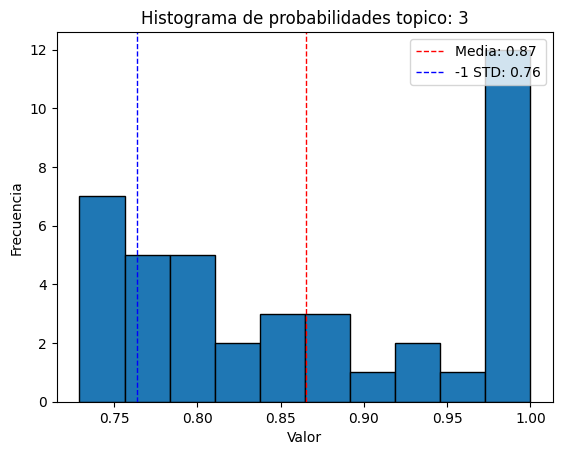

In [20]:
# Calcular la media, el desvío estándar

mean = np.mean([fila[2] for fila in reg_data])
std_dev = np.std([fila[2] for fila in reg_data])

# Crear el histograma
plt.hist([fila[2] for fila in reg_data], bins=10, edgecolor='black')

# Añadir líneas para la media, la moda y el desvío estándar
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Media: {mean:.2f}')
plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=1, label=f'-1 STD: {mean - std_dev:.2f}')


# Añadir títulos y etiquetas
plt.title(f'Histograma de probabilidades topico: {topic_id}')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

In [21]:
# Definir la función de estilo
def color_rows(row, label, value):
    if row[label] >= value:
        return ['color: cyan'] * len(row)
    else:
        return [''] * len(row)

# Calcular la media
threshold = df_query.score.mean()

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(f"Umbral de corte {threshold}")

df_query.sort_values('score', ascending=False, inplace=True)
df_query.style.apply(lambda row: color_rows(row, 'score', threshold), axis=1).set_properties(subset=['titulo'], **{'text-align': 'left'})

Topico N°: 3 --> 3_sendas_camiones_residuos
Umbral de corte 0.8652804878048781


,ID,titulo,score
20,114855058,"Manes le habló al arquero Milei: ""Las pelotas que van afuera no las meta adentro del arco""",1.000000
32,114857812,L-Gante se cayó a la fosa de un escenario en Paraguay,1.000000
24,114847609,Terminó la renovación integral y el jueves reabre la estación Pasteur-AMIA,1.000000
26,114822410,Ethereum: cuál es la cotización de esta criptomoneda,1.000000
13,114881107,Se tomó un avión y en pleno despegue descubrió que sus valijas estaban tiradas en la pista,1.000000
21,114851041,LA MATANZA: ASESINARON A UN JOVEN – RADIO EN VIVO,1.000000
9,114846569,El descuido de Enzo Fernández por el que quieren multar a toda la Selección Argentina,1.000000
31,114861494,"Baja el dólar, los bonos vuelven a caer y el riesgo país supera los 1600 puntos",1.000000
3,114816786,"La ONU llamó al régimen de Corea del Norte a poner fin al trabajo forzado, la esclavitud y las prácticas esclavistas",1.000000
2,114830629,Industria: el uso de la capacidad instalada cayó 11 puntos en mayo,1.000000


#### Documentos mas representativos de un topico

- [1]  Desde el metodo del modelo

In [22]:
docs_representative = topic_model.get_representative_docs(topic=topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
docs_representative

Topico N°: 3 --> 3_sendas_camiones_residuos


['La Secretaría de Ambiente y Espacio Público a través de la Dirección de Higiene Urbana erradicó 30 puntos crónicos de arrojo de residuos ubicados en distintos sectores de la ciudad en los primeros seis meses de 2024 Las tareas –que forman parte de las acciones periódicas que se llevan a cabo para mejorar los espacios de uso público– se ejecutaron en los barrios 23 de febrero Acindar Alvear Bella Vista Fisherton Fisherton Industrial Fisherton Norte Fontanarrosa Hospitales Larrea Las Flores Ludueña Roca Martín A Santa Lucía Santa Lucía Viejo Santa Teresita y Triángulo y Moderno Los trabajos incluyeron limpieza de cada lugar relleno con tierra de sectores donde se producen anegamientos colocación de pretiles que además fueron pintados para mayor visibilidad y mesas y bancos tipo Z También se colocó cartelería con la leyenda «Cuidemos nuestro barrio» Los espacios públicos intervenidos están ubicados en Avenida Pellegrini y Carriego barrio Bella Vista distrito Oeste Saavedra 6100 Felipe M

- [2] Por similitud coseno del topico a los tres documento mas cercanos

In [23]:
# Obtenemos la matriz de similitud coseno entre topicos y documentos
sim_matrix = cosine_similarity(topic_model.topic_embeddings_, docs_embedding)
sim_matrix.shape

(9, 500)

In [24]:
# Similitud coseno entre el topico y los documentos del topico elegido
s_coseno = []
for i in docs_per_topics:
    s_coseno.append(cosine_similarity([topic_model.topic_embeddings_[topic_id + 1]], [docs_embedding[i]])[0][0])

# Indices
idx_coseno_sort = np.argsort(s_coseno)[::-1]

print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )

for idx in idx_coseno_sort[:3]:
    print(idx, df_parquet.iloc[docs_per_topics[idx]].title)


Topico N°: 3 --> 3_sendas_camiones_residuos
32 L-Gante se cayó a la fosa de un escenario en Paraguay
21 LA MATANZA: ASESINARON A UN JOVEN – RADIO EN VIVO
33 Al menos 21 muertos por caída de un ómnibus a un abismo en Perú


- [3] Primer documento mas cercano al embedding del topico

In [25]:
# Documento de maxima similitud con el topico

simil_docs_topic = sim_matrix[topic_id+ 1].argmax()
print(f"Noticia de maxima similitud con el topico: {topic_id}")
print(f"Doc ID: {df_parquet.index[simil_docs_topic]}")
print(f"Titulo: {df_parquet.iloc[simil_docs_topic].title}")
best_doc = data[simil_docs_topic]

Noticia de maxima similitud con el topico: 3
Doc ID: 7138
Titulo: L-Gante se cayó a la fosa de un escenario en Paraguay


#### Keywords de un topico (modelo)

In [26]:
# Obtener las palabras clave para un topico dado
topic_keywords = topic_model.get_topic(topic_id)
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
print(topic_keywords)

Topico N°: 3 --> 3_sendas_camiones_residuos
[('sendas', 0.04788483098955453), ('camiones', 0.04144611615673001), ('residuos', 0.04139452329668747), ('vecinos', 0.04019490746922541), ('indicaciones proporcionadas', 0.03894483379243303), ('distrito', 0.03878659880285258), ('puente', 0.037157428226719), ('agua', 0.0326089368232948), ('ropa adecuada', 0.03259470021085322), ('calzado antideslizante', 0.03259470021085322)]


#### Keywords de un topico (otra forma de obtenerlos)

In [27]:
keywords = topic_model.topic_representations_[topic_id]
topic_keywords = [TopicKeyword(name=keyword, score=score) for keyword, score in keywords if keyword != '']
print(f"Topico N°: {topic_id} --> {topic_labels[topic_id+1]}" )
topic_keywords

Topico N°: 3 --> 3_sendas_camiones_residuos


[{'name': 'sendas', 'score': 0.04788483098955453},
 {'name': 'camiones', 'score': 0.04144611615673001},
 {'name': 'residuos', 'score': 0.04139452329668747},
 {'name': 'vecinos', 'score': 0.04019490746922541},
 {'name': 'indicaciones proporcionadas', 'score': 0.038944833...},
 {'name': 'distrito', 'score': 0.03878659880285258},
 {'name': 'puente', 'score': 0.037157428226719},
 {'name': 'agua', 'score': 0.0326089368232948},
 {'name': 'ropa adecuada', 'score': 0.03259470021085322},
 {'name': 'calzado antideslizante', 'score': 0.03259470021085...}]

### Top keywords de un topico

In [28]:
# Calculo de umbral de corte para las keywords
def keywords_umbral(topic_keywords):
    freq_k = []
    for name_score in topic_keywords:
        freq_k.append(name_score['score'])
    umbral_k = np.array(freq_k).mean()
    print(f"umbral keywords: {umbral_k}")

    topic_keywords_top = {}
    for name_score in topic_keywords:
        if name_score['score'] >= umbral_k:
            topic_keywords_top[name_score['name']] = name_score['score']

    return topic_keywords_top

keywords_umbral(topic_keywords)

umbral keywords: 0.03836075759792033


{'sendas': 0.04788483098955453,
 'camiones': 0.04144611615673001,
 'residuos': 0.04139452329668747,
 'vecinos': 0.04019490746922541,
 'indicaciones proporcionadas': 0.03894483379243303,
 'distrito': 0.03878659880285258}

### Top Entities de un topico

In [29]:
threshold = df_query.score.mean()
print(f"umbral entities: {threshold}")

entities_topic = []
for doc_ID in list(df_query[df_query["score"] > threshold]['ID']):
    entities_topic.append(get_entities_news(doc_ID))

# Crear un diccionario para contar en cuántos documentos aparece cada palabra
document_frequencies = defaultdict(int)

# Crear un conjunto para cada documento y contar las palabras únicas
for lista in entities_topic:
    unique_words = set(lista)
    for palabra in unique_words:
        document_frequencies[palabra] += 1

# Ordenar las palabras por la frecuencia de documentos de mayor a menor
sorted_frequencies = sorted(document_frequencies.items(), key=lambda item: item[1], reverse=True)

# Calcular el umbral
freq_e = [item[1] for item in sorted_frequencies]
umbral_e = np.mean(freq_e)

# Obtener el resultado ordenado de las primeras 10 entidades segun criterio de corte
topic_entities_top = {}
c=0
for idx in range(len(sorted_frequencies)):
    if sorted_frequencies[idx][1] >= umbral_e:
        if c != 10:
            topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]
        else:
            break
        c += 1 

    elif len(topic_entities_top) <= 3:
        topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]

topic_entities_top



umbral entities: 0.8652804878048781


{'Argentina': 2, 'Gobierno': 2, 'Facundo Manes': 1, 'Lionel Messi': 1}

### Obtener los titulos de noticias del topico filtrado por umbral de corte 

In [30]:
topic_documents_title, threshold = topic_documents(topic_id, topic_model, df_parquet)
print(threshold)
topic_documents_title

0.8652804878048781


['Manes le habló al arquero Milei: "Las pelotas que van afuera no las meta adentro del arco"',
 'L-Gante se cayó a la fosa de un escenario en Paraguay',
 'Terminó la renovación integral y el jueves reabre la estación Pasteur-AMIA',
 'Ethereum: cuál es la cotización de esta criptomoneda',
 'Se tomó un avión y en pleno despegue descubrió que sus valijas estaban tiradas en la pista',
 'LA MATANZA: ASESINARON A UN JOVEN – RADIO EN VIVO',
 'El descuido de Enzo Fernández por el que quieren multar a toda la Selección Argentina',
 'Baja el dólar, los bonos vuelven a caer y el riesgo país supera los 1600 puntos',
 'La ONU llamó al régimen de Corea del Norte a poner fin al trabajo forzado, la esclavitud y las prácticas esclavistas',
 'Industria: el uso de la capacidad instalada cayó 11 puntos en mayo',
 'El nuevo parche en la camiseta de la selección argentina tras ganar la Copa América',
 'Video: violento asalto a una familia de Córdoba mientras miraba en su casa la final de la Copa América.',


### Generar un nombre de topico con LLM ( Open AI)
- Validar OPENAI_API_KEY en .env

In [31]:
get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client)

'Actualidad y noticias diversas'

### Grabar todos los registros en Topic y actualizar en News

In [37]:
# Grabar todos los topicos en la base
date_choice = choice[:4]+"-"+choice[4:6]+"-"+choice[6:8]

for topic_id in topic_model.get_topics().keys():
    if topic_id > -1:

        topic_keywords_top  = top_keywords(topic_id, topic_model, PATH)
        topic_entities_top  = top_entities(topic_id, topic_model, df_parquet)
        topic_documents_title, threshold  = topic_documents(topic_id, topic_model, df_parquet)
        id_best_doc, title_best_doc, best_doc = best_document(topic_id, topic_model, docs_embedding, id_data, title_data, data)
        

        topic_doc = Topic(
            index = topic_id,
            name = get_topic_name(''.join(topic_documents_title), topic_id, topic_model, client),
            vector = list(topic_model.topic_embeddings_[topic_id + 1 ]),
            similarity_threshold = threshold,
            created_at = datetime.now(),
            from_date = parse(date_choice),
            to_date = datetime.strptime(date_choice, '%Y-%m-%d') + timedelta(days=1),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()

In [ ]:
# Marcar registros de noticias como procesados y grabar sus embeddings, topicos, etc 
update_news( id_data, idx_data, docs_embedding, topics, probs ) 

### Recuperar todos los topicos desde el indice Topic de la base

In [38]:
index_name = 'topic'

topics_list = []
for i, doc in enumerate(Topic.search().query().scan()):
    topics_list.append(doc.to_dict())
    print(topics_list[i]['index'], topics_list[i]['name'])

0 Temas de actualidad y noticias.
1 Hábitos y eventos sociales actuales
2 Actualidad y noticias diversas
3 Actualidad y noticias diversas
4 Solidaridad y eventos sociales recientes
5 Problemas sociales y económicos en Argentina
6 Deportes y actualidad en Argentina
7 Transformaciones y eventos en Argentina


### Busqueda de 5 documentos del indice news de la base correspondiente a un topico
** (devuelve los docs que han sido marcados en el campo process en True )

In [40]:
topic = 1
topic_embedding = topics_list[topic]['vector']

index_name = 'news'
# Crear una consulta KNN para buscar embeddings cercanos
knn_query = {
    "size": 5,  # Número de resultados que deseas obtener
    "query": {
        "bool": {
            "must": [
                {
                    "knn": {
                        "vector": {
                            "vector": topic_embedding,
                            "k": 10  # Número de vecinos más cercanos
                        }
                    }
                },
                {
                    "term": {
                        "process": True  # Solo incluir documentos donde 'process' es True
                    }
                }
            ],
            "filter": {
                "exists": {
                    "field": "vector"  # Solo incluir documentos que tienen el campo 'vector'
                }
            }
        }
    }
}
# Realizar la búsqueda
response_topic = os_client.search(index=index_name, body=knn_query)

# Obtener el tópico más cercano
if response_topic['hits']['total']['value'] > 0:
    for i in [hit['_source']['title'] for hit in response_topic['hits']['hits']]:
        print(i)
else:
    print("No se encontraron documentos cercanos al topico dado.")

No se encontraron documentos cercanos al topico dado.


### Recuperar de la base el documento mas cercano a un topico

In [ ]:
index_name = 'topic'
search_query = {
    'query': {
        'match': {
            'index': 10  # Sustituir 'campo' y 'valor' por campo y valor de búsqueda
        }
    }
}

# Realizar la búsqueda
response = os_client.search(
                            body=search_query,
                            index=index_name
)

texto = response['hits']['hits'][0]['_source']

#Imprimir los resultados
print(f"Topico: {response['hits']['hits'][0]['_source']['name']}")
print("\n"+ texto['best_doc'])

### Nuevo documento consultando embeddings generados por el modelo

In [ ]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)
sim_matrix_new = cosine_similarity(topic_model.topic_embeddings_, new_doc_embedding.reshape(1, -1))

idx = np.argmax(sim_matrix_new)-1         # Topicos desde -1, 0, 1, ..., n
print(topics_list[idx]['index'], topics_list[idx]['name'])

### Nuevo documento consultando embeddings de la base

In [ ]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)

# Buscamos en la base a que topico pertenece el nuevo documento
knn_query = {
    "size": 1,
    "query": {
        "knn": {
            "vector": {
                "vector": new_doc_embedding,
                "k" : 3
            }
        }
    }
}
response = os_client.search(index='topic', body=knn_query)

if response['hits']['total']['value'] > 0:
    print(f"Topico: {response['hits']['hits'][0]['_source']['name']}")
    print(f"Estimacion: {response['hits']['hits'][0]['_score']}")
else:
    print(f"Topico no encontrado")

### Graficar los topicos en 3d

In [ ]:
import plotly.express as px

# Obtener los embeddings de los tópicos
topic_embeddings = topic_model.topic_embeddings_

new_doc = "Fuga de presos en San Telmo"
new_doc_embedding = topic_model.embedding_model.embed([new_doc])[0]

total = np.vstack((topic_embeddings, new_doc_embedding))

# Reducir la dimensionalidad de los embeddings a 3D usando UMAP
umap_model = UMAP(n_components=3)
embeddings_3d = umap_model.fit_transform(total)

# Obtener las etiquetas de los tópicos
topics_labels = [str(i)+" "+name['name'] for i, name in enumerate(topics_list) ]

# Crear un DataFrame para Plotly
df = pd.DataFrame(embeddings_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df['Topico'] = ["-1"] + topics_labels + ['>>'+new_doc[:15]] # Identificamos el nuevo documento
df['Etiqueta'] = list(range(-1, len(topic_embeddings)-1)) + [new_doc[:15]]

# Graficar los tópicos en 3D de manera interactiva usando Plotly, ajustando el tamaño del gráfico
fig = px.scatter_3d(df, x='Dim1', y='Dim2', z='Dim3', color='Topico', text='Etiqueta', title='Visualización 3D de Tópicos con BERTopic')


# Ajustar el tamaño del gráfico
fig.update_layout(
    autosize=False,
    width=1200,  # Ancho del gráfico
    height=800,  # Altura del gráfico
    margin=dict(l=65, r=50, b=65, t=90)
)

# Mostrar el gráfico
fig.show()

### Busqueda de un documento por su indice, topico asociado, keywords, entities.

In [ ]:

index_name = 'news'
search_query = {
    'query': {
        'match': {
            '_id': '105594124'
        }
    }
}

# Realizar la búsqueda
response = os_client.search(
                            body=search_query,
                            index=index_name
)
print(f"Texto de Noticia: {response['hits']['hits'][0]['_source']['news'][:200]}...\n")

new_doc_embedding = topic_model.embedding_model.embed(response['hits']['hits'][0]['_source']['news'])

# Define el índice y el campo del vector
index_name = 'topic'
vector_field = 'vector'

# Crear una consulta KNN para buscar el embedding más similar
knn_query = {
    "size": 1,  # Número de resultados que deseas obtener, en este caso 1
    "query": {
        "knn": {
            vector_field: {
                "vector": new_doc_embedding,
                "k": 3  # Número de vecinos más cercanos
            }
        }
    }
}

# Realizar la búsqueda
response_topic = os_client.search(index=index_name, body=knn_query)

# Obtener el tópico más cercano
if response_topic['hits']['total']['value'] > 0:
    closest_topic = response_topic['hits']['hits'][0]['_source']
    print(f"El nuevo documento pertenece al tópico: {closest_topic['index']}")
    print(closest_topic['name'])
    print(f"Estimacion: {closest_topic['similarity_threshold']}")
    print(f"Keywords del topico: {closest_topic['keywords']}")
    print(f"Entidades del topico: {closest_topic['entities']}")

else:
    print("No se encontró un tópico cercano.")

#### Agrupando por embeddings cercanos

In [ ]:
# Eliminamos el topico -1
new_topic_embeddings = topic_embeddings[1:]

# Calcular la similitud del coseno entre los embeddings de los tópicos
similarities = cosine_similarity(new_topic_embeddings)

# Crear una matriz de similitud excluyendo la diagonal
np.fill_diagonal(similarities, 0)

# Encontrar los pares de tópicos más cercanos
topic_pairs = np.dstack(np.unravel_index(np.argsort(similarities.ravel())[::-1], similarities.shape))[0]

# Mostrar los 5 pares de tópicos más cercanos
for i in range(10):
    topic_id_1, topic_id_2 = topic_pairs[i]
    similarity_score = similarities[topic_id_1, topic_id_2]
    print(f"Topico {topic_id_1} y Topico {topic_id_2} tienen una similitud de: {similarity_score:.4f}")

### Recuperar topicos de Opensearch dado una fecha

In [ ]:
def get_topics_opensearch(date_filter=None):

    index_name = 'topic'
    if date_filter:
        # Crear el rango de fecha para filtrar el mismo día completo
        date_filter_gte = f"{date_filter}T00:00:00"
        date_filter_lte = f"{date_filter}T23:59:59"

        query = {
            "size": 100,  
            "query": {
                "bool": {
                    "must": [
                        {"range": {"to_date": {"gte": date_filter_gte, "lte": date_filter_lte}}}
                    ]
                }
            }
        }
    else:
        query = {
            "query": {
                "match_all": {}
            }
        }
    
    response = os_client.search(index=index_name, body=query)

    topics = [hit['_source'] for hit in response['hits']['hits']]
    return topics



topics_os = get_topics_opensearch(date_filter="2024-04-02")

for i in enumerate([hit['name'] for hit in topics_os]):
    print(i)

### Obtener la ultima fecha actualizada de cualquier topico

In [ ]:
def format_date(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S.%f')
    formatted_date = date_obj.strftime('%Y-%m-%d %H:%M')
    return formatted_date

In [ ]:

db_topics = []
data_topics = {}
for reg in topics_os:
    index = reg['index']
    name = reg['name']
    vector = reg['vector']
    similarity_threshold = reg['similarity_threshold']
    create_at = format_date(reg['created_at'])
    from_date = reg['from_date'][:10]
    to_date = reg['to_date'][:10]
    title_best_doc = reg['title_best_doc']
    id_best_doc = reg['id_best_doc']

    db_topics.append([index, name, round(similarity_threshold, 4), create_at, from_date, to_date])
    data_topics[index] = [name,
                          vector,
                          title_best_doc,
                          reg['best_doc'],
                          reg['entities'],
                          reg['keywords'],
                          similarity_threshold]

# Convertir a DataFrame
df = pd.DataFrame(db_topics, columns=["indice", "nombre", "umbral", "creado", "desde", "hasta"])                      
df

In [ ]:
db_news = get_news()

In [ ]:
# Crear un diccionario para agrupar los registros por fecha (solo día, mes y año)
def dates_count(db_news) -> dict:
    fechas_dict = defaultdict(list)

    # Agrupar registros por fecha
    for registro in db_news:
        fecha_completa = registro[-1]
        fecha_solo_dia = fecha_completa.split('T')[0]  # Tomar solo el día, mes y año
        if fecha_solo_dia not in fechas_dict:
            fechas_dict[fecha_solo_dia] = 1
        else:
            fechas_dict[fecha_solo_dia] += 1
    
    return fechas_dict

In [ ]:
def funcion_aux(ID):
    keywords_df = df_parquet[df_parquet.index==ID]['Keyword Name'].values[0]
    entities_df = df_parquet[df_parquet.index==ID]['Entity Name'].values[0]
    fila = df_parquet.index.get_loc(ID)
    print(f"Noticia ID: {ID} {df_parquet[df_parquet.index==ID]['in__title'].values}\n")
    print(f"Entities de dataframe: {entities_df}")
    print(f"Keywords de dataframe: {keywords_df}")
    print("-"*80)
    print(f"Fila: {fila}")
    print(f"Prob. modelo: {probs[fila]}")
    #print(f"Entities calculadas: {entities[fila]}")
    #print(f"Keywords calculadas: {filtered_k_w_n[fila]}")

funcion_aux(105558429)

### Buscar n noticias de la base relacionadas a un topico

In [ ]:
topic = 13
topic_embedding = data_topics[topic][1]
print("Topico: ", data_topics[topic][0])

# Buscamos en la base los documentos del topico elegido
knn_query = {
    "size": 100,
    "query": {
                "knn": {
                        "vector": {
                            "vector": topic_embedding,
                            "k": 120
                        }
                }
            }
    }

response = os_client.search(index='news', body=knn_query)
[f"{str(hit['_score'])} : {hit['_source']['title']}" for hit in response['hits']['hits']]

In [ ]:
id_news     = [hit['_id'] for hit in response['hits']['hits']]
title_news  = [hit['_source']['title'] for hit in response['hits']['hits']]
score_news  = [hit['_score'] for hit in response['hits']['hits']]

others_docs = []
for i in range(len(id_news)):
    others_docs.append([id_news[i], title_news[i], score_news[i]])

df_other_docs = pd.DataFrame(others_docs, columns=['indice', 'titulo', 'probs']) 
df_other_docs

In [ ]:

# Cargar el modelo
embedding_model_x = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Lista de documentos o frases
sentences = ["Este es un documento de ejemplo.", "Otro ejemplo de documento para generar embedding."]

# Generar embeddings
embeddings_x = embedding_model_x.encode(sentences)

# Imprimir los embeddings
for i, embedding in enumerate(embeddings_x):
    print(f"Documento {i+1}: {embedding}")

In [ ]:
len(embeddings_x)

In [ ]:
topic = 14
documents_ids = [entry['id'] for entry in doc_info if entry['topic'] == topic]
documents_ids

In [ ]:
len(documents_ids)

In [ ]:
def update_news(documents_ids: list, docs_embedding, topics: list) -> bool:
    """
    Marcar en True los registros de noticias procesadas y guardar el embedding correspondiente.
    """

    if len(documents_ids) != len(docs_embedding):
        raise ValueError("El número de IDs de documentos y embeddings no coinciden.")
        return False
    
    index_name = 'news'

    # Construir el cuerpo de la solicitud para el API _bulk
    acciones = []
    for doc_id, embedding, topic in zip(documents_ids, docs_embedding, topics):
        update_body = { 
                        "doc": {
                            "vector": embedding,
                            "topics": topic,   
                            "process": True,
                        }
        }
        accion = {
            "_op_type": "update",
            "_index": index_name,
            "_id": doc_id,
            "doc": update_body["doc"]
        }
        acciones.append(accion)

    # Realizar la actualización por lotes
    helpers.bulk(os_client, acciones)

    return True

In [ ]:
for doc_id, embedding, topic in zip(documents_ids, docs_embedding, topics):
    print(doc_id, embedding, topic)
    break

In [ ]:
query = {
    "size": 100,
    "query": {
        "bool": {
            "must": [
                {"term": {
                    "topics": 10
                }}
            ],
        }
    }
}
                    
response = os_client.search(index='news', body=query)

In [ ]:
for i in [hit['_id'] for hit in response['hits']['hits']]:
        print(i)

In [ ]:
docs_per_topics

In [ ]:
titles_per_topic

In [ ]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

clean_data = Cleaning_text()

count_vectorizer = CountVectorizer(
                    tokenizer=None,
                    token_pattern=r'(?u)\b\w\w+\b',
                    encoding ='utf-8',
                    ngram_range=(1, 2),
                    max_df=0.8, # significa que cualquier término que aparezca en más del 0.x % de los documentos será ignorado.
                    min_df=2,
                    stop_words=SPANISH_STOPWORDS,
                    # vocabulary=all_tokens,
                    )

nmf_model = NMF(n_components= 2, init='nndsvd' )



In [ ]:
from sklearn.cluster import KMeans

topic = 17
# topic = np.random.randint(0, len(docs_per_topics)-1) # Aleatorio

docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic]
probs = topic_model.probabilities_[docs_per_topics]
corpus = [data[doc] for doc in docs_per_topics]

titles_per_topic = [df_parquet.iloc[doc]['in__title'] for doc in docs_per_topics]
titles_per_topic

In [ ]:
proc_data = []
for data_in in corpus:
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = clean_data.str_lower(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)

corpus_vect = count_vectorizer.fit_transform(proc_data)

sim = cosine_similarity(corpus_vect, corpus_vect)

# Aplica K-means clustering para dividir en 2 grupos
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(sim)

# Obtiene las etiquetas de los clusters
labels = kmeans.labels_


A = [title if labels[i] == 1 else " " for i, title in enumerate(titles_per_topic) ]
B = [title if labels[i] == 0 else " " for i, title in enumerate(titles_per_topic) ]

data_combined = np.stack((labels, A, B), axis=1)

combined = pd.DataFrame(data_combined)
combined
